In [14]:
# import eland official API
# check it on https://github.com/elastic/eland
import eland as ed

# other imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import elasticsearch-py client
from elasticsearch import Elasticsearch

# Function for pretty-printing JSON
def json(raw):
    import json
    print(json.dumps(raw, indent=2, sort_keys=True))

In [17]:
# Connect to an Elasticsearch instance
# here we use the official Elastic Python client
# check it on https://github.com/elastic/elasticsearch-py
es = Elasticsearch(
  ['http://localhost:9200'],
  http_auth=("es_kbn", "changeme")
)

In [18]:
# print the connection object info (same as visiting http://localhost:9200)
# make sure your elasticsearch node/cluster respond to requests
json(es.info())

{
  "cluster_name": "churn",
  "cluster_uuid": "K3nB4fp_QcyjpY-e2XVUbA",
  "name": "node-01",
  "tagline": "You Know, for Search",
  "version": {
    "build_date": "2020-07-22T19:31:37.655268Z",
    "build_flavor": "default",
    "build_hash": "bbbd2282a6668869c41efc5713ad8214d44c0ad1",
    "build_snapshot": true,
    "build_type": "zip",
    "lucene_version": "8.6.0",
    "minimum_index_compatibility_version": "7.0.0",
    "minimum_wire_compatibility_version": "7.10.0",
    "number": "8.0.0-SNAPSHOT"
  }
}


In [23]:
# Load the dataset from the local csv file of call logs
pd_df = pd.read_csv("./Desktop/telcos-ecs/churn/customers.csv").dropna()
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   record_id               3333 non-null   int64 
 1   state                   3333 non-null   object
 2   account_length          3333 non-null   int64 
 3   phone_number            3333 non-null   object
 4   international_plan      3333 non-null   object
 5   voice_mail_plan         3333 non-null   object
 6   number_vmail_messages   3333 non-null   int64 
 7   customer_service_calls  3333 non-null   int64 
 8   churn                   3333 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 260.4+ KB


In [25]:
# Load the data into elasticsearch
df = ed.pandas_to_eland(
    pd_df=pd_df,
    es_client=es,

    # Where the data will live in Elasticsearch
    es_dest_index="es-customers",

    # Type overrides for certain columns, this can be used to customize index mapping before ingest
    es_type_overrides={
        "record_id": "keyword",
        "state": "keyword",
        "account_length": "short",
        "phone_number": "keyword",
        "international_plan": "keyword",
        "voice_mail_plan": "keyword",
        "number_vmail_messages": "short",
        "customer_service_calls": "short",
        "churn": "short"
    },

    # If the index already exists what should we do?
    es_if_exists="replace",

    # Wait for data to be indexed before returning
    es_refresh=True,
)
df.info()

<class 'eland.dataframe.DataFrame'>
Index: 3333 entries, 0 to 3332
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   account_length          3333 non-null   int64 
 1   churn                   3333 non-null   int64 
 2   customer_service_calls  3333 non-null   int64 
 3   international_plan      3333 non-null   object
 4   number_vmail_messages   3333 non-null   int64 
 5   phone_number            3333 non-null   object
 6   record_id               3333 non-null   object
 7   state                   3333 non-null   object
 8   voice_mail_plan         3333 non-null   object
dtypes: int64(4), object(5)
memory usage: 64.0 bytes


In [26]:
json(es.indices.get_mapping(index="es-customers"))

{
  "es-customers": {
    "mappings": {
      "properties": {
        "account_length": {
          "type": "short"
        },
        "churn": {
          "type": "short"
        },
        "customer_service_calls": {
          "type": "short"
        },
        "international_plan": {
          "type": "keyword"
        },
        "number_vmail_messages": {
          "type": "short"
        },
        "phone_number": {
          "type": "keyword"
        },
        "record_id": {
          "type": "keyword"
        },
        "state": {
          "type": "keyword"
        },
        "voice_mail_plan": {
          "type": "keyword"
        }
      }
    }
  }
}


In [27]:
# Shape is determined by using count API
df.shape

(3333, 9)

In [ ]:
ed_customers = ed.read_es('es_kbn:es_kbn@localhost:9200', 'customers')

In [37]:
# DataFrame has many APIs compatible with Pandas

#df.head(10)
#df.columns
#df.phone_number
#df["churn"]
#df[df.churn.isin(["1", "0"])]
print(df[df.churn.isin(["1", "0"])].es_info())
#print(df.tail(10).es_info())

es_index_pattern: es-customers
Index:
 es_index_field: _id
 is_source_field: False
Mappings:
 capabilities:
                                 es_field_name  is_source es_dtype es_date_format pd_dtype  is_searchable  is_aggregatable  is_scripted aggregatable_es_field_name
account_length                  account_length       True    short           None    int64           True             True        False             account_length
churn                                    churn       True    short           None    int64           True             True        False                      churn
customer_service_calls  customer_service_calls       True    short           None    int64           True             True        False     customer_service_calls
international_plan          international_plan       True  keyword           None   object           True             True        False         international_plan
number_vmail_messages    number_vmail_messages       True    short           

In [38]:
# Aggregating values
df.describe()

,account_length,churn,customer_service_calls,number_vmail_messages
count,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,0.144914,1.562856,8.099010
std,39.816132,0.352015,1.315294,13.686312
min,1.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,1.000000,0.000000
50%,100.257143,0.000000,1.000000,0.000000
75%,127.180000,0.000000,2.000000,19.545455
max,243.000000,1.000000,9.000000,51.000000


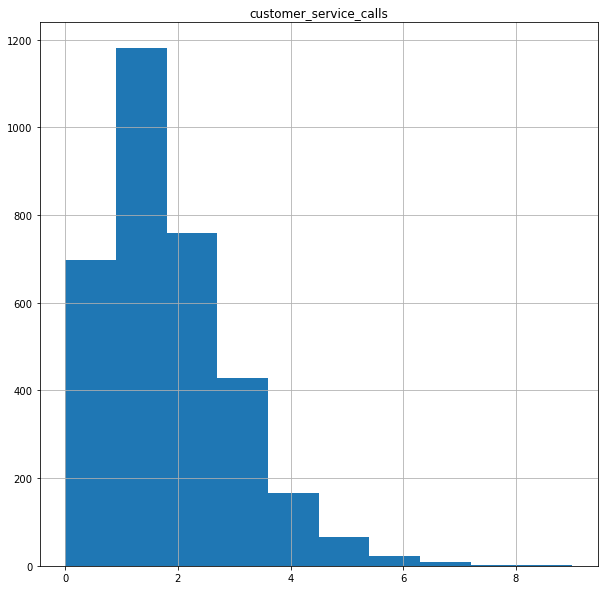

In [41]:
# Plotting with matplotlib
from matplotlib import pyplot as plt

df[["customer_service_calls"]].hist(figsize=[10,10])
plt.show()

In [47]:
# es_query() allows for the full Elasticsearch querying capabilities
df.es_query({
  "range": {
    "customer_service_calls": {
      "gte": 8,
      "lte": 10
    }
  }
})

,account_length,churn,customer_service_calls,international_plan,number_vmail_messages,phone_number,record_id,state,voice_mail_plan
542,152,1,9,yes,20,415-416-2778,542,MN,yes
1502,64,0,8,no,40,510-333-8822,1502,SC,yes
1912,103,1,8,no,0,408-371-1727,1912,NH,no
2380,53,1,9,no,0,408-416-6886,2380,NJ,no


In [48]:
# Pull a subset of your data for building graphs / operations locally.
sample_df = df[df.churn == "1"].sample(100).to_pandas()
sample_df.info()
print(type(sample_df))

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 1038 to 985
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   account_length          100 non-null    int64 
 1   churn                   100 non-null    int64 
 2   customer_service_calls  100 non-null    int64 
 3   international_plan      100 non-null    object
 4   number_vmail_messages   100 non-null    int64 
 5   phone_number            100 non-null    object
 6   record_id               100 non-null    int64 
 7   state                   100 non-null    object
 8   voice_mail_plan         100 non-null    object
dtypes: int64(5), object(4)
memory usage: 7.8+ KB
<class 'pandas.core.frame.DataFrame'>


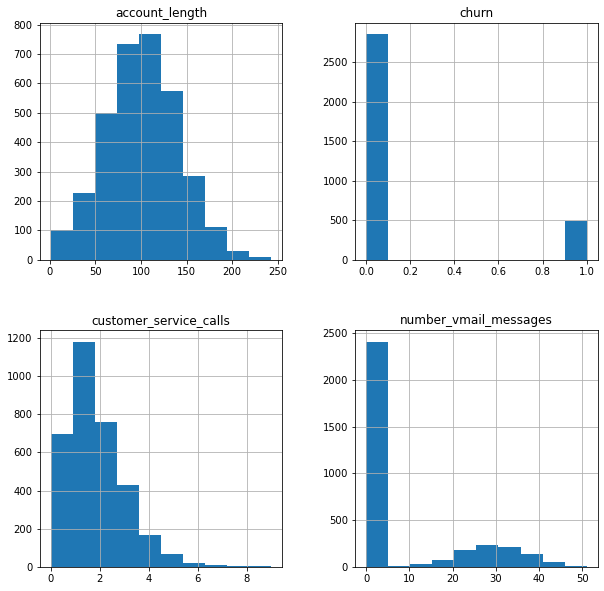

In [49]:
df.select_dtypes(include=np.number).hist(figsize=[10,10])
plt.show()